In [ ]:
!pip install tensorflow==2.9

In [ ]:
!unzip "/content/drive/MyDrive/Lung_Cancer_Balanced.zip"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,GlobalAvgPool2D,GaussianNoise,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# import tensorflow as tf
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#   try:
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=3072)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
test_set="/content/Lung_Cancer_Balanced/test"
train_set="/content/Lung_Cancer_Balanced/train"

In [3]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
test_datagen= ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size = (224,224),
    batch_size = 8,
    class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size = (224,224),
    batch_size = 8,
    shuffle=True,
    class_mode = 'categorical')

Found 8000 images belonging to 2 classes.
Found 1056 images belonging to 2 classes.


In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
es= EarlyStopping(monitor="accuracy",min_delta=0.01,patience=5,verbose=1,mode='auto')
mc=ModelCheckpoint(monitor="accuracy",filepath="/content/drive/MyDrive/Phase II Project Work/lung_balanced.h5",verbose=1,save_best_only=True,mode='auto')
cd=[es,mc]

In [7]:
import tensorflow as tf
base_model = tf.keras.applications.EfficientNetB2(weights='imagenet', input_shape=(224,224,3), include_top=False)
# base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', input_shape=(224,224,3), include_top=False)
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 gaussian_noise (GaussianNoi  (None, 7, 7, 1408)       0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               360704    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                        

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall'])

In [9]:
hs=model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=75,
    verbose=1,
    validation_data=test_generator,
    callbacks=cd
    )

Epoch 1/20
75/75 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283
Epoch 1: accuracy improved from -inf to 0.92833, saving model to /content/drive/MyDrive/Phase II Project Work/lung_balanced.h5
75/75 [==============================] - 67s 653ms/step - loss: 0.2450 - accuracy: 0.9283 - precision: 0.9283 - recall: 0.9283 - val_loss: 0.1386 - val_accuracy: 0.9498 - val_precision: 0.9498 - val_recall: 0.9498
Epoch 2/20
75/75 [==============================] - ETA: 0s - loss: 0.2760 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083
Epoch 2: accuracy did not improve from 0.92833
75/75 [==============================] - 44s 590ms/step - loss: 0.2760 - accuracy: 0.9083 - precision: 0.9083 - recall: 0.9083 - val_loss: 0.5815 - val_accuracy: 0.7121 - val_precision: 0.7121 - val_recall: 0.7121
Epoch 3/20
75/75 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400
Epoch

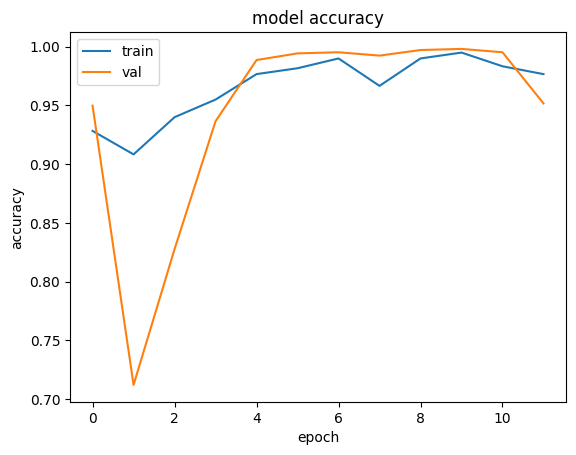

In [10]:
from matplotlib import pyplot as plt
plt.plot(hs.history['accuracy'])
plt.plot(hs.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()